In [49]:
%matplotlib inline

# Visualize Results

In [2]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

from io import StringIO
import pandas as pd
import requests

In [91]:
# Everthing in this cell is already defined in settings and utils

pitch_length = 105
pitch_width = 68

ajax_red = '#e40615'
ajax_white = '#ffffff'
ajax_yellow = '#f7be2f'

# Define denominators for normalization
denominators = {
    'x': pitch_length,
    'y': pitch_width,
    'v_y': 13,
    'v_y': 13,
    'a_y': 10,
    'a_y': 10,
    'acc': 20,
    'pac': 20,
    'sta': 20,
    'height': 2.10,
    'weight': 110,
    'distance_to_ball': round(np.sqrt((pitch_length**2 + pitch_width**2)), 2),
    'angle_to_ball': 360,
    'orientation': 360,
    'tiredness': 10,
    'short_tiredness': 1,
}

# Define a function to calculate zoom based on the desired image size in plot coordinates
def calculate_zoom(img_path, desired_size_in_plot_units, ax):
    # Open the image to get its pixel dimensions
    with Image.open(img_path) as img:
        dpi = ax.figure.dpi
        fig_width_in_inches = ax.figure.get_size_inches()[0]
        fig_height_in_inches = ax.figure.get_size_inches()[1]
        
        # Convert plot units to inches (assuming both axes are linear)
        plot_units_to_inches_width = fig_width_in_inches / (ax.get_xlim()[1] - ax.get_xlim()[0])
        plot_units_to_inches_height = fig_height_in_inches / (ax.get_ylim()[1] - ax.get_ylim()[0])
        
        # Calculate desired width and height in inches
        desired_width_in_inches = desired_size_in_plot_units * plot_units_to_inches_width
        desired_height_in_inches = desired_size_in_plot_units * plot_units_to_inches_height
        
        # Calculate the zoom factors needed for the image to fit within the desired width and height
        zoom_width = desired_width_in_inches / (img.width / dpi)
        zoom_height = desired_height_in_inches / (img.height / dpi)
        
        # Return the smaller zoom factor to ensure the entire image fits within the desired dimensions
        return min(zoom_width, zoom_height)

# Define a function to draw an image at a specific location on the plot
def draw_image(ax, x, y, img_path, max_width):
        zoom = calculate_zoom(img_path, max_width, ax)
        image = plt.imread(img_path)
        imagebox = OffsetImage(image, zoom=zoom)  # Start with a small, fixed zoom
        ab = AnnotationBbox(imagebox, (x, y), frameon=False, xycoords='data')
        ax.add_artist(ab)

# Fetches data from a Google Sheets CSV URL and converts it into a DataFrame
def google_sheet_to_df(url):
    # Fetch the CSV data from the URL
    response = requests.get(url)
    response.raise_for_status()

    # Decode the response text
    response.encoding = 'utf-8'

    # Read the CSV data into a pandas DataFrame
    data = StringIO(response.text)
    data_df = pd.read_csv(data)
    return data_df

# Load Football Manager data
def load_FM_data():
    # Load the data from the Google Sheets URL
    fm_players_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ0KwlS1KWQWSNHwpDAyOK5O-0tGC0H6nNapPHNEXGTdmPTBHgDnYm9HyMrdZ79dbLKe1KYDnzOvrno/pub?gid=303039767&single=true&output=csv"
    fm_players_df = google_sheet_to_df(fm_players_url)

    return fm_players_df

# Load nationalitiy data
def load_nationality_data():
    # Load the data from the Google Sheets URL
    nationalities_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQwC-bEG5W_zpX8lrAWpQyaWGMw54mHcjI6YNGOlAISrOHnt7Ya4TbV2V-42tt3nKh_zE5x9pOF8EcK/pub?gid=729290581&single=true&output=csv"
    nationalities_df = google_sheet_to_df(nationalities_url)

    return nationalities_df

In [57]:
fm_players_df = load_FM_data()
nationalities_df = load_nationality_data()

## Visualize based on nationality

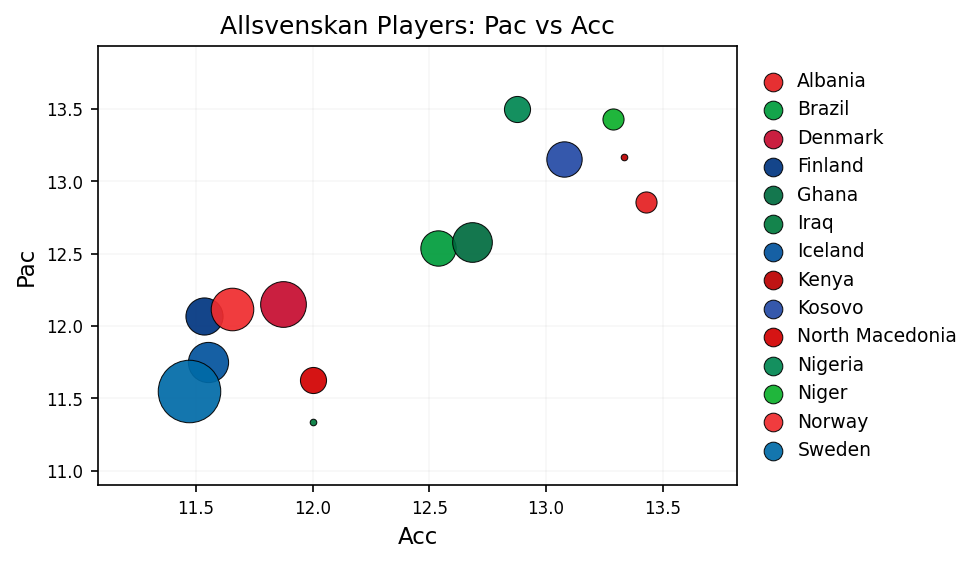

In [57]:
# Function to get the color of a country by its ISO 3166-1 alpha-3 code
def get_country_info(nat_iso, field='Color'):
    return nationalities_df[nationalities_df['ISO'] == nat_iso].iloc[0][field]

def calculate_marker_size(num_players, player_threshold, num_biggest_country):
    """
    Calculate marker size based on the number of players.
    """
    min_size = 10
    max_size = 900
    size_range = max_size - min_size
    scaling_factor = np.log(num_biggest_country - player_threshold)
    return min_size + (size_range * (np.log(num_players - player_threshold) / scaling_factor))

# Plot how two parameters compare to each other for Allsvenskan players from different nationalities
def visualize_parameter_comparison_nationality(data_df, x_param, y_param):
    # Create a figure and axis
    _, _ = plt.subplots(figsize=(5.5, 3.8), dpi=150)

    # Define variables
    player_threshold = 5
    num_biggest_country = len(data_df[fm_players_df['Nationality'] == 'SWE'])

    # Initialize variables to track min and max values
    min_x, max_x = float('inf'), float('-inf')
    min_y, max_y = float('inf'), float('-inf')

    # Grouping by Nationality
    grouped_df = data_df.groupby('Nationality')

    # Plotting scatter plots for each country
    for country, data in grouped_df:
        if len(data) > player_threshold:
            # Define values
            x = data[x_param].mean()
            y = data[y_param].mean()
            color = get_country_info(country, 'Color')
            name = get_country_info(country, 'Country')
            marker_size = calculate_marker_size(len(data), player_threshold, num_biggest_country)

            # Update min and max values
            min_x, max_x = min(min_x, x), max(max_x, x)
            min_y, max_y = min(min_y, y), max(max_y, y)
            
            # Plot the scatters
            plt.scatter(x, y, c=color, alpha=0.92, s=marker_size, zorder=2, edgecolor='black', linewidth=0.5)
            plt.scatter([], [], c=color, alpha=0.92, s=80, zorder=2, edgecolor='black', linewidth=0.5, label=name)    # Legend marker

    # Set x and y limits based on min and max values
    padding_x = (max_x - min_x) * 0.2
    padding_y = (max_y - min_y) * 0.2
    plt.xlim(min_x - padding_x, max_x + padding_x)
    plt.ylim(min_y - padding_y, max_y + padding_y)

    # Set fontsize of tick labels
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Adding labels and legend
    plt.xlabel(f'{x_param}', fontsize=11)
    plt.ylabel(f'{y_param}', fontsize=11)
    plt.title(f'Allsvenskan Players: {y_param} vs {x_param}')
    plt.legend(loc='center left', fontsize=9, bbox_to_anchor=(1, 0.5), frameon=False, handletextpad=0.3)

    # Set opacity of grid lines
    plt.grid(True, alpha=0.1)

    # Show plot
    plt.show()

x_param = 'Acc'
y_param = 'Pac'
visualize_parameter_comparison_nationality(fm_players_df, x_param, y_param)

## Visualize based on team

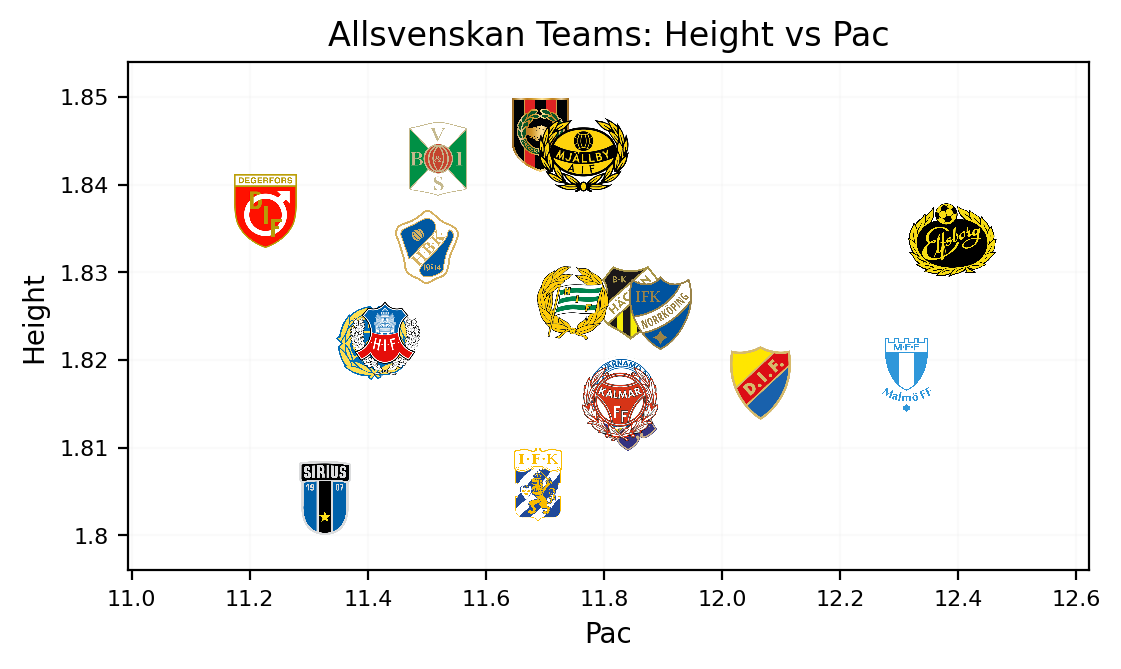

In [59]:
# Define denominators for normalization
round_factor = {
    'x': 0,
    'y': 0,
    'v_y': 1,
    'v_y': 1,
    'a_y': 1,
    'a_y': 1,
    'acc': 1,
    'pac': 1,
    'sta': 1,
    'height': 2,
    'weight': 0,
    'distance_to_ball': 0,
    'angle_to_ball': 0,
    'orientation': 0,
    'tiredness': 1,
}

# Plot how two parameters compare to each other for Allsvenskan players from different teams
def visualize_parameter_comparison_team(data_df, x_param, y_param):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6.2, 3.3), dpi=200)

    # Initialize variables to track min and max values
    min_x, max_x = float('inf'), float('-inf')
    min_y, max_y = float('inf'), float('-inf')

    # Grouping by Tea
    grouped_df = data_df.groupby('Team')

    # Plotting scatter plots for each team
    for team, data in grouped_df:
        # Calculating the mean of the x and y values
        x = data[x_param].mean() / denominators[x_param.lower()]
        y = data[y_param].mean() / denominators[y_param.lower()]

        # Update min and max values
        min_x, max_x = min(min_x, x), max(max_x, x)
        min_y, max_y = min(min_y, y), max(max_y, y)

        # Plot the team logo
        img_path = f'images/logos/{team}.png'
        draw_image(ax, x, y, img_path, max_width=0.04)

    # Set x and y limits based on min and max values
    padding_x = (max_x - min_x) * 0.2
    padding_y = (max_y - min_y) * 0.2
    plt.xlim(min_x - padding_x, max_x + padding_x)
    plt.ylim(min_y - padding_y, max_y + padding_y)

    # Define formatter functions
    def x_tick_formatter(val, pos):
        return f'{round(val * denominators[x_param.lower()], round_factor[x_param.lower()])}'

    def y_tick_formatter(val, pos):
        return f'{round(val * denominators[y_param.lower()], round_factor[y_param.lower()])}'

    # Apply formatters to the x and y axes
    ax.xaxis.set_major_formatter(FuncFormatter(x_tick_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(y_tick_formatter))

    # Set fontsize of tick labels
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Adding labels and legend
    plt.xlabel(f'{x_param}', fontsize=10)
    plt.ylabel(f'{y_param}', fontsize=10)
    plt.title(f'Allsvenskan Teams: {y_param} vs {x_param}')

    # Set opacity of grid lines
    plt.grid(True, alpha=0.05)

    # Show plot
    plt.show()

x_param = 'Pac'
y_param = 'Height'
visualize_parameter_comparison_team(fm_players_df, x_param, y_param)

## Visualize correlation matrix

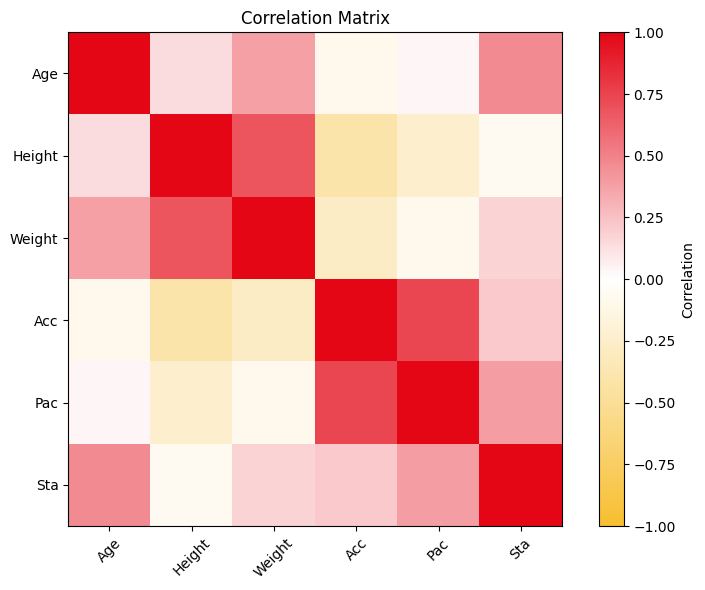

In [55]:
# Plot how two the feautres in the dataset correlate with each other
def visualize_correlation_matrix(data_df, features):
    # Calculate correlation matrix
    correlation_matrix = data_df[features].corr()

    # Define the colormap with a gradient between the specified colors
    colors = [ajax_yellow, ajax_white, ajax_red]
    cmap = LinearSegmentedColormap.from_list('Custom', colors, N=256)

    # Plot correlation matrix as heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(correlation_matrix, cmap=cmap, interpolation='nearest', vmin=-1.0, vmax=1.0)
    plt.colorbar(label='Correlation')
    plt.title('Correlation Matrix')
    plt.xticks(ticks=np.arange(len(correlation_matrix.columns)), labels=correlation_matrix.columns, rotation=45)
    plt.yticks(ticks=np.arange(len(correlation_matrix.index)), labels=correlation_matrix.index)
    plt.tight_layout()
    plt.show()

features = ['Age', 'Height', 'Weight', 'Acc', 'Pac', 'Sta']
visualize_correlation_matrix(fm_players_df, features)

## Visualize tiredness

In [169]:
# Mockup data
player_name = 80 * ["Gyslain Ngongo"]
jersey_number = 80 * [11] 
team = 80 * ['AIK']
long_tiredness = np.linspace(0, 4, 80)
short_tiredness =  [0.116, 0.164, 0.204, 0.240, 0.270, 0.276, 0.268, 0.248, 0.214, 0.176,
                    0.152, 0.130, 0.102, 0.082, 0.064, 0.042, 0.044, 0.060, 0.078, 0.116,
                    0.164, 0.204, 0.240, 0.270, 0.276, 0.268, 0.248, 0.214, 0.176, 0.152,
                    0.130, 0.102, 0.082, 0.064, 0.042, 0.044, 0.060, 0.078, 0.116, 0.164,
                    0.116, 0.164, 0.204, 0.240, 0.270, 0.276, 0.268, 0.248, 0.214, 0.176,
                    0.152, 0.130, 0.102, 0.082, 0.064, 0.042, 0.044, 0.060, 0.078, 0.116,
                    0.164, 0.204, 0.240, 0.270, 0.276, 0.268, 0.248, 0.214, 0.176, 0.152,
                    0.130, 0.102, 0.082, 0.064, 0.042, 0.044, 0.060, 0.078, 0.116, 0.164]

# Create a DataFrame with the mockup data
frames = {
    'long_tiredness': long_tiredness,
    'short_tiredness': short_tiredness,
    'team': team,
    'jersey_number': jersey_number,
    'player_name': player_name
}

# Create a DataFrame with the mockup data
frames_df = pd.DataFrame(frames)

In [95]:
allsvenskan_blue = '#044f89'
allsvenskan_yellow = '#ffd718'
allsvenskan_ligth_yellow = '#ffec8b'

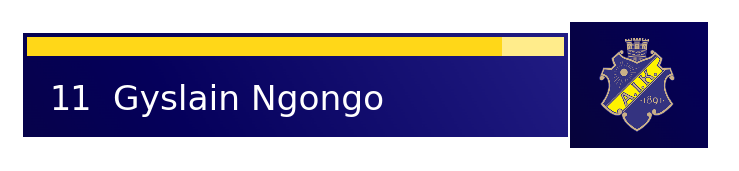

In [172]:
from matplotlib.animation import FuncAnimation

# Draw a rectangle in matplotlib
def draw_rectangle(ax, x, y, width, height, color, alpha=1.0, zorder=1):
    rect = plt.Rectangle((x, y), width, height, linewidth=0, edgecolor='none', facecolor=color, alpha=alpha, zorder=zorder)
    ax.add_patch(rect)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1), dpi=150)

# Draw background gradients
draw_image(ax, 0.5, 0.5, 'images/gradients/gradient_1.png', max_width=0.33)
draw_image(ax, 1.14, 0.5, 'images/gradients/gradient_2.png', max_width=0.4)

# Draw team logo
team = frames_df.iloc[0]['team']
img_path = f'images/logos/{team}.png'
draw_image(ax, 1.136, 0.5, img_path, max_width=0.3)

# Draw the jersey number
plt.text(0.08, 0.35, f"{frames_df.iloc[0]['jersey_number']}", fontsize=16, color=ajax_white, ha='center', va='center')

# Draw the player name
player_name = frames_df.iloc[0]['player_name']
font_size = 20 - len(player_name) / 4 if len(player_name) > 8 else 20
plt.text(0.16, 0.35, f"{player_name}", fontsize=font_size, color=ajax_white, ha='left', va='center')


# Define function to update scatter plots for a specific frame
def update_bar(frame):
    # Clear previous scatters, text, etc
    for patch in ax.patches[:]:
        patch.remove()

    frame_df = frames_df.iloc[frame]

    # White bar
    draw_rectangle(ax, 0, 0.8, 1, 0.2, ajax_white, alpha=1, zorder=2)

    # Update the bar based on the tiredness values
    long_width = 1 - max(frame_df['long_tiredness'] / denominators['tiredness'], 0)
    draw_rectangle(ax, 0, 0.8, long_width, 0.2, allsvenskan_ligth_yellow, alpha=1, zorder=3)

    short_width = long_width - max(frame_df['short_tiredness'] / denominators['short_tiredness'], 0)
    draw_rectangle(ax, 0, 0.8, short_width, 0.2, allsvenskan_yellow, alpha=1, zorder=4)

plt.xlim(0, 1.3)
plt.ylim(-0.1, 1.1)
plt.axis('off')

# Create the animation
animation = FuncAnimation(fig, update_bar, frames=range(0, len(frames_df)), repeat=False, interval=80)

# Specify the GIF file path
gif_name = f"animations/tiredness_bar.gif"

# Save the animation as a GIF file
animation.save(gif_name, writer='pillow')

# # Specify the MP4 file path
# mp4_name = "animations/tiredness_bar.mp4"

# # Save the animation as an MP4 file
# animation.save(mp4_name, writer='ffmpeg')